In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from dataset import get_dataset
import torchvision
import numpy as np
from arch import DQN_Conv

# Tải mô hình đơn giản (ví dụ: ResNet)
from arch import CONV_MNIST

# 1. Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Tải mô hình đã huấn luyện trước
model = CONV_MNIST()
model.load_state_dict(torch.load('trained_model/mnist_cnn_best.pth'))

model.eval().to(device)  # Đặt chế độ đánh giá (evaluation mode)

# 3. Định nghĩa FGSM Attack
def fgsm_attack(image, epsilon, gradient):
    # Lấy dấu của gradient
    sign_gradient = gradient.sign()

    new_sign = torch.zeros(28, 28)
    for i in range(28):
        for j in range(28):
            x, y = i//2, j//2
            new_sign[i][j] = torch.mean(sign_gradient[0][0][x*2:x*2+2, y*2:y*2+2])

    new_sign = new_sign.sign()
    
    # sign_gradient[sign_gradient] = 0
    # Tạo mẫu tấn công
    perturbed_image = image + epsilon * new_sign.to(device)
    # Giới hạn giá trị pixel [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image, sign_gradient

def fgsm_attack_2(image, epsilon, mask):
    # 14*14 -> 28*28
    fit_mask = torch.zeros(image.shape)
    for i in range(14):
        for j in range(14):
            fit_mask[0][0][i*2][j*2] = mask[i][j]
            fit_mask[0][0][i*2+1][j*2] = mask[i][j]
            fit_mask[0][0][i*2][j*2+1] = mask[i][j]
            fit_mask[0][0][i*2+1][j*2+1] = mask[i][j]
    # Tạo mẫu nhiễu
    perturbed_image = image + epsilon * fit_mask.to(device)
    # Giới hạn giá trị pixel [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# 4. Chuẩn bị dữ liệu
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = get_dataset('mnist', split='train')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 5. Tấn công mẫu đầu tiên
epsilon = 0.2  # Mức độ nhiễu
criterion = nn.CrossEntropyLoss()


dqn = DQN_Conv(28*28, 14*14)
dqn.load_state_dict(torch.load('model_0_trrenvong_2.pth'))
dqn.eval().to(device)


C:\Users\hokha\AppData\Local\Temp\ipykernel_3400\3960380247.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_model/mnist_cnn_be

DQN_Conv(
  (classifier): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=1024, bias=True)
    (8): Tanh()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): Tanh()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=128, out_features=196, bias=True)
  )
)

  0%|          | 0/60000 [00:00<?, ?it/s]

Distance FGSM: 2.7282707691192627
Label gốc: 9, FGSM: 8
CC: 9
Distance CC: 2.7128283977508545


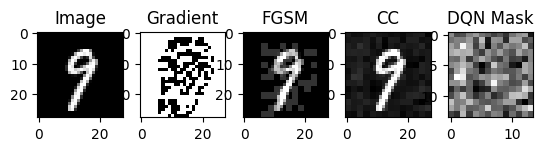

  0%|          | 1/60000 [00:00<8:30:10,  1.96it/s]

Distance FGSM: 3.3720133304595947
Label gốc: 5, FGSM: 9
CC: 5
Distance CC: 2.641231060028076


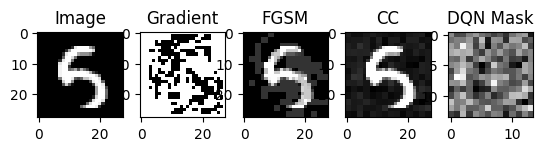

  0%|          | 2/60000 [00:00<6:58:13,  2.39it/s]

Distance FGSM: 3.452535390853882
Label gốc: 5, FGSM: 8
CC: 5
Distance CC: 2.622645854949951


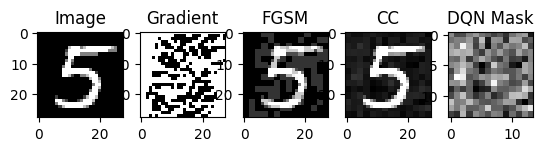

  0%|          | 3/60000 [00:01<6:19:21,  2.64it/s]

Distance FGSM: 3.5142617225646973
Label gốc: 6, FGSM: 6
CC: 6
Distance CC: 2.610227346420288


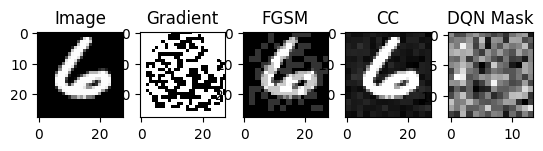

  0%|          | 4/60000 [00:01<8:39:48,  1.92it/s]

Distance FGSM: 3.0774245262145996
Label gốc: 2, FGSM: 8
CC: 2
Distance CC: 2.7152018547058105


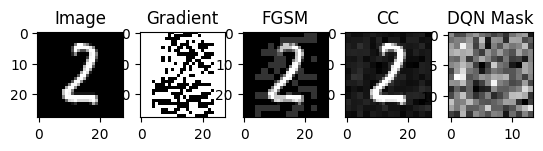

  0%|          | 5/60000 [00:02<8:41:15,  1.92it/s]

Distance FGSM: 3.0841610431671143
Label gốc: 3, FGSM: 3
CC: 3
Distance CC: 2.565613031387329


KeyboardInterrupt: 

In [32]:

t = 30

from tqdm import tqdm

total = 0
correct = 0

for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)

    img_2_channel = torch.concatenate((images, images), 1)
    dqn_predict = dqn(img_2_channel)
    predict = dqn_predict.argmax(1)

    dqn_img = dqn_predict.view(14, 14).detach().cpu().numpy()
    #normalize
    dqn_img = (dqn_img - dqn_img.min()) / (dqn_img.max() - dqn_img.min())
    # 1 if > 0 else 0
    # dqn_img = np.where(dqn_img > 0, 1, 0)


    # print(f"Predict: {dqn_img}")
    # dqn_img = np.zeros((14, 14))
    # dqn_img[predict//14, predict%14] = 1
    
    # Đặt chế độ tính gradient
    images.requires_grad = True
    
    # Dự đoán ban đầu
    outputs = model(images)

    start_label = outputs.argmax(1).item()

    loss = criterion(outputs, labels)
    
    # Tính gradient
    model.zero_grad()
    loss.backward()
    gradient = images.grad.data

    # grid_img = np.zeros((14, 14))
    # for i in range(14):
    #     for j in range(14):
    #         grid_img[i, j] = gradient[0, 0, i*2:(i+1)*2, j*2:(j+1)*2].mean().item()

    grid_img = gradient.view(28, 28).detach().sign().cpu().numpy()
    # 0 if < 0 else 1
    grid_img = np.where(grid_img < 0, 0, 1)

    # Tạo mẫu nhiễu
    perturbed_image, sign_gradient = fgsm_attack(images, epsilon, gradient)

    distance = torch.norm(perturbed_image - images)
    print(f"Distance FGSM: {distance}")
    
    # Kiểm tra dự đoán trên mẫu bị tấn công
    outputs_perturbed = model(perturbed_image)
    _, final_pred = outputs_perturbed.max(1)
    
    print(f"Label gốc: {start_label}, FGSM: {final_pred.item()}")

    attack2_image = fgsm_attack_2(images, epsilon, torch.tensor(dqn_img).float().to(device))
    outputs_perturbed2 = model(attack2_image)
    _, final_pred2 = outputs_perturbed2.max(1)
    print(f"CC: {final_pred2.item()}")
    distance2 = torch.norm(attack2_image - images)
    print(f"Distance CC: {distance2}")

    # Hiển thị mẫu gốc, grad và mẫu bị tấn công
    import matplotlib.pyplot as plt
    plt.figure()
    plt.subplot(151)
    plt.imshow(images.squeeze().cpu().detach().numpy(), cmap='gray')
    plt.title('Image')
    plt.subplot(152)
    plt.imshow(grid_img, cmap='gray')
    plt.title('Gradient')
    plt.subplot(153)
    plt.imshow(perturbed_image.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title('FGSM')
    plt.subplot(154)
    plt.imshow(attack2_image.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title('CC')
    plt.subplot(155)
    plt.imshow(dqn_img, cmap='gray')
    plt.title('DQN Mask')


    plt.show()
    
    t -= 1
    if t == 0:
        break
    # total += 1
    # if start_label != final_pred2.item():
    #     correct += 1

    # print(f"Accuracy: {correct/total}")

# print(f"Accuracy: {correct/total}")